In [1]:
import pandas as pd 
import wandb
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

api = wandb.Api()

In [3]:
# Project is specified by <entity/project-name>
# tags = ['pfsp-fixedelo','symmetric','asymmetric','k=0']
tags = ['behind_only']
history_dataframes = []
for tag in tags:
    training_runs = api.runs("amar-research/safetyh",
                    filters={"config.eval": True,
                            "config.max_steps": 10000,
                            "tags" : tag}
                    )


    for run in tqdm(training_runs, desc="Processing Training Runs"):
        ego_version = run.config['ego_version']
        npc_version = run.config['npc_version']
        history = run.scan_history()
        episodes = history.max_step
        tags = run.tags
        sampling = run.config['model_sampling']
            
        history_dataframes.append((run.history(samples=episodes, x_axis="_step", pandas=(True), stream="default"),tags, ego_version, npc_version, sampling))


Processing Training Runs: 100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


In [ ]:
list_of_dicts = []
for df, tags, ego, npc, sampling in history_dataframes:
    mean = df['rollout/sr100'].mean()
    std = df['rollout/sr100'].std()
    if 'asymmetric' in tags:
        config = 'PFSP-Asymmetric'
    elif 'symmetric' in tags:
        config = 'PFSP-AK-32'
    elif 'k=0' in tags:
        config = 'PFSP-AK-0'
    elif 'pfsp-fixedelo' in tags:
        if sampling == 'prioritized':
            config = 'PFSP'
        elif sampling == 'uniform':
            config = 'FSP'
        elif sampling == 'sequential':
            config = 'Sequential'
    list_of_dicts.append({"ego_version": ego, "npc_version": npc+1, "mean": mean, "std": std, "config": config})


In [ ]:
data_list = []
list_of_dicts = []

with open("crashes.txt", "r") as file:
    for line in file:
        data_list.append(line.strip())

# Parse the Crashes into Model Versions
# Every few rows there should be a Model Version
data = {}

for idx, line in enumerate(data_list):
    if "Model" in line:
        cfg = line.split(":")[1].strip()
        # Assuming `cfg` is the variable containing the specific value
        data[cfg] = {}

    if line.startswith('Scenario:'):
        # Extract the scenario name
        scenario = line.split(': ')[1]
        # Create an empty list to store the cycles lines
        data[cfg][scenario] = []
    # Check if the line starts with 'Cycle'
    elif line.startswith('Cycle'):
        # Extract the cycle information
        cycle_info = line.split(': ')
        mean = float(cycle_info[2].split(',')[0])
        stdev = float(cycle_info[3])
        # Append the cycle information to the cycles list
        data[cfg][scenario].append((mean, stdev))
        # Check if the line starts with 'Scenario:' again, indicating the next scenario 

print(data.keys())
print(data['AdjustableK_C5_100000'].keys())
print(data['AdjustableK_C5_100000']['Slowdown'])

for config in data.keys():
    for scenario in data[config].keys():
        for idx, deets in enumerate(data[config][scenario]):
            if 'AdjustableK_C5_100000_Asymmetric' in config:
                cfg = 'PFSP-Asymmetric'
            elif 'AdjustableK_C5_100000' in config:
                cfg = 'PFSP-AK-32'
            elif 'K0_C5_100000' in config:
                cfg = 'PFSP-AK-0'
            elif "SequentialTraining_C5" in config:
                cfg = 'Sequential'
            elif "UniformSampling_C5_100000" in config:
                cfg = 'FSP'
            elif "PrioritizedSampling_C5_100000_FixedUpdate" in config:
                cfg = 'PFSP'
            list_of_dicts.append({"ego_version": idx+1, "mean": deets[0], "std": deets[1], "config": cfg, "scenario": scenario})


dict_keys(['AdjustableK_C5_100000', 'AdjustableK_C5_100000_Asymmetric', 'UniformSampling_C5_100000', 'PrioritizedSampling_C5_100000_FixedUpdate', 'K0_C5_100000', 'SequentialTraining_C5'])
dict_keys(['Slowdown', 'SlowdownSameLane', 'SpeedUp', 'CutIn'])
[(0.21, 0.40730823708832603), (0.25, 0.4330127018922193), (0.35, 0.4769696007084728), (0.44, 0.4963869458396343), (0.26, 0.4386342439892262)]


/Users/amar/miniforge3/envs/safetyh/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:#4c72b0'` for same effect.
  warnings.warn(msg, FutureWarning)
/Users/amar/miniforge3/envs/safetyh/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:#4c72b0'` for same effect.
  warnings.warn(msg, FutureWarning)
/Users/amar/miniforge3/envs/safetyh/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:#4c72b0'` for same effect.
  warnings.warn(msg, FutureWarning)
/Users/amar/miniforge3/envs/safetyh/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprec

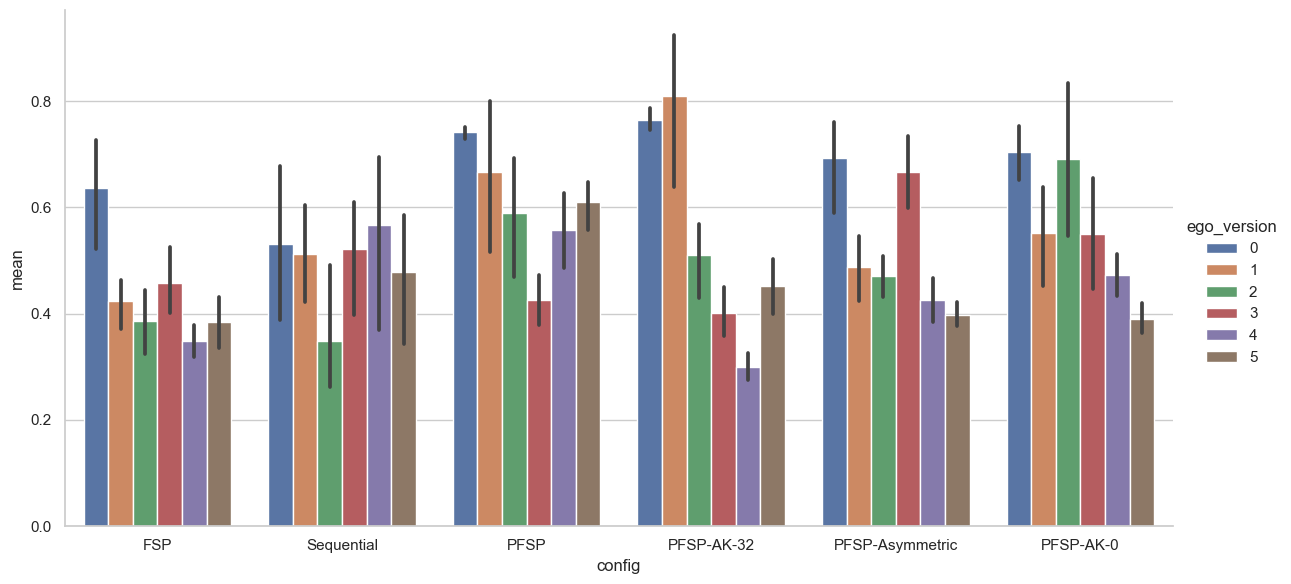

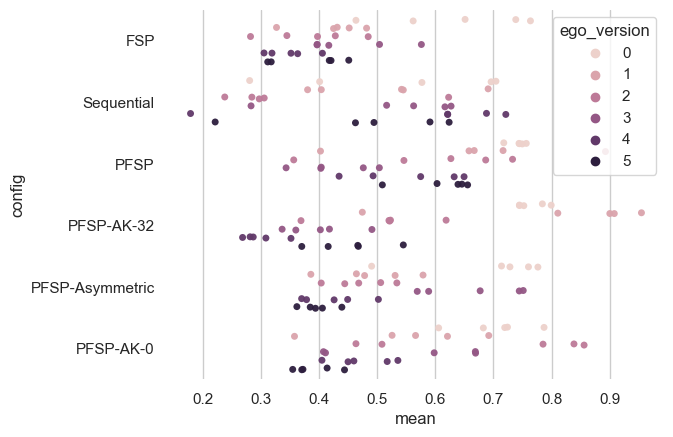

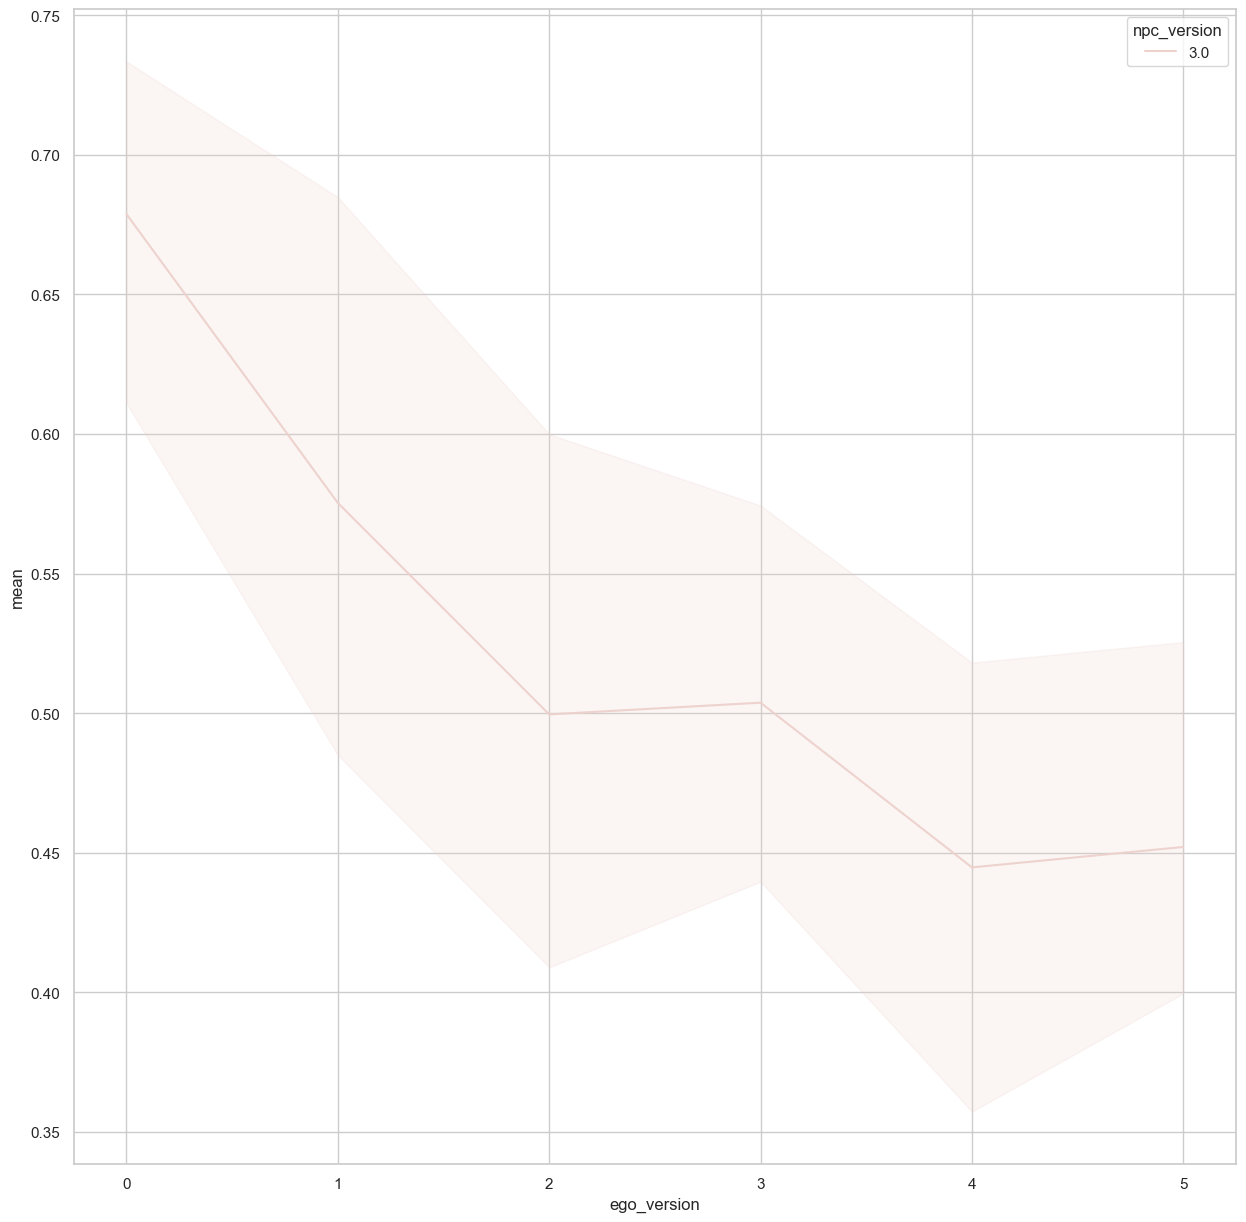

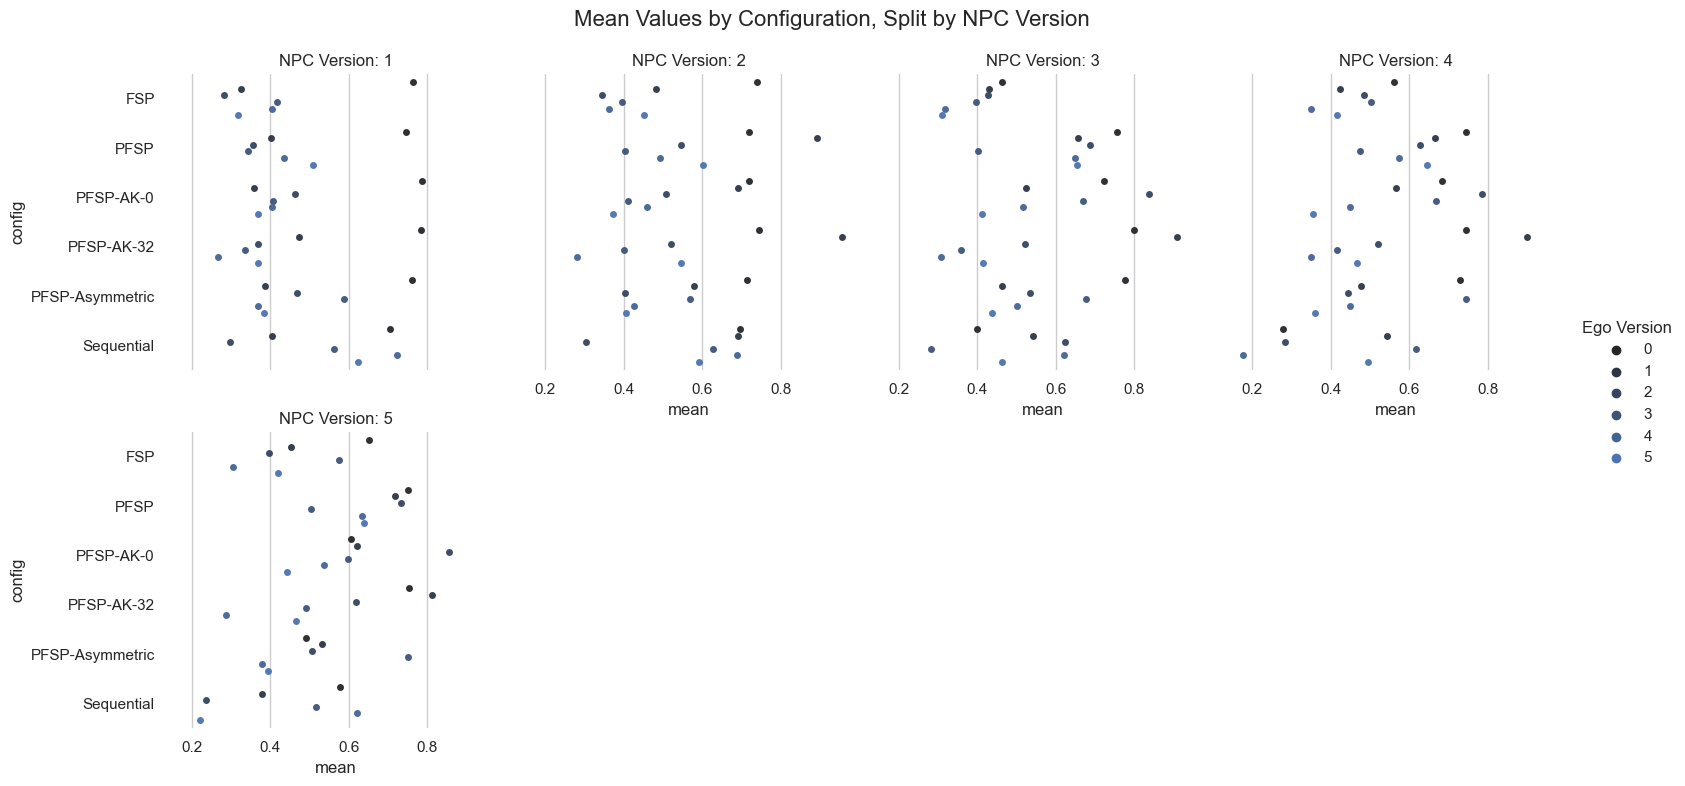

In [ ]:

eval_dataframe = pd.DataFrame(list_of_dicts)
eval_filt = eval_dataframe.groupby(['ego_version', 'config']).mean().reset_index()

sns.set_theme(style="whitegrid")
# Bar Plot
sns.catplot(data=eval_dataframe, x="config", y="mean", hue="ego_version", kind="bar", height=6, aspect=2)




f, ax = plt.subplots()
sns.despine(bottom=True, left=True)
sns.stripplot(
    data = eval_dataframe, x = "mean", y = "config", hue="ego_version", dodge=True, alpha=.95, zorder=1, legend = True,
)

f, ax = plt.subplots(figsize = (15,15))
sns.lineplot(eval_filt, x = "ego_version", y = "mean", hue="npc_version", alpha=.95,legend = True, markers=True, dashes=False)
# Ensure data is grouped and mean is recalculated for each group
eval_filt = eval_dataframe.groupby(['ego_version', 'npc_version', 'config']).mean().reset_index()

# Set up the Seaborn FacetGrid to split by 'npc_version'
g = sns.FacetGrid(eval_filt, col="npc_version", col_wrap=4, height=4, aspect=1)
g.map_dataframe(sns.stripplot, x="mean", y="config", hue="ego_version", dodge=True, alpha=.95)

# Further customization for the plots
g.set_titles("NPC Version: {col_name}")
g.add_legend(title='Ego Version')
g.figure.subplots_adjust(top=0.9)  # Adjust the top to make room for suptitle
g.figure.suptitle('Mean Values by Configuration, Split by NPC Version', fontsize=16)

# Removing the extra margins around the axes
for axes in g.axes.flat:
    sns.despine(ax=axes, bottom=True, left=True)

plt.show()